# Prediction of Customer Outflow

The goal of any business is to make a profit. Distribution of resources is also associated with profit: it makes sense to invest the resources of the enterprise in what brings profit.
Telecom operators are no exception. In the modern market, each of them offers a different range of services and several tariff plans - in order to attract and satisfy the needs of the largest number of users.
All things being equal, the more customers you have the more profit you get. It is also known that it is cheaper for almost any business to retain an existing customer than to attract a new one. From this point of view, it is important to have at your disposal a tool that predicts the outflow of customers, and direct the company's resources in the form of personal conditions, promotions to retain such customers.
In this study, we will analyze the data of the telecom operator Niedinogorazryva.com, which offers two main types of services to customers:
1. Fixed telephone connection. It is possible to connect a telephone set to several lines at the same time.
2. Internet. Connection can be of two types: via telephone line or fiber optic cable.

The following services are also available:
- Internet security: antivirus and blocking of unsafe sites;
- Dedicated technical support line;
- Cloud file storage for data backup;
- Streaming TV and movie catalog.

Data about users, tariffs and services are contained in the following csv files:
- `contract.csv` - information about the contracts;
- `personal.csv` - personal data of the clients;
- `internet.csv` - information about Internet services;
- `phone.csv` - information about telephony services.

**The purpose of this study** is to build an optimal prediction model for classifying customers in terms of outflow.


**Research progress**:

We will try to build a prediction model based on the data about Niedinogorazryv.com subscribers, for this we have to preprocess the data, explore it, divide it into samples, possibly adjust the balance of classes, choose the most appropriate model for training, train it in the best way by setting up the appropriate hyperparameters, check the quality of the model on the test sample. Our quality metric will be AUC-ROC, that is, the area under the ROC-curve. The higher its value, the better the model. The established threshold is not less than 0.88.


Thus, this project will include the following steps:
* data preprocessing and data discovery
* preparing data for building a model
* model selection and training
* model quality check

## Data Overview



In [1]:
import numpy as np  # importing numpy
import pandas as pd  # importing pandas
import os.path as path # importing os.path for path handling
import seaborn as sns # importing seaborn 
from scipy import stats as st # importing stats functions 
import seaborn as sns # importing seaborn for plotting
import matplotlib.pyplot as plt  # importing matplotlib for plotting
%matplotlib inline
import warnings # importing warnings to avoid them
warnings.simplefilter("ignore")
import phik # importing phik for features analysis
from catboost import CatBoostClassifier # importing Catboost
from sklearn.model_selection import train_test_split  # importing the function
from sklearn.model_selection import  RandomizedSearchCV # importing RandomSearchCV to search for the best hyperparameters
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, f1_score, roc_curve  # importing necessary metrics
import datetime as dt # импортируем datetime for dates handling
from lightgbm import LGBMClassifier # importing LGBM
from sklearn.linear_model import LogisticRegression # importing Logistic Regression
from sklearn.ensemble import RandomForestClassifier  # importing  Random Forest
from sklearn.pipeline import make_pipeline, Pipeline # importing for pipeline creation
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder # importing features preprocessing tools
from sklearn.compose import ColumnTransformer # importing features preprocessing tool
from sklearn.dummy import DummyClassifier # importing  Dummy for sanity check

C:\Users\Tatiana\anaconda3\envs\praktikum_new\lib\site-packages\sklearn\linear_model\least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
C:\Users\Tatiana\anaconda3\envs\praktikum_new\lib\site-packages\sklearn\linear_model\least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html

Let's make the first representation about the data. For viewing and analysing, we read the files in csv format, save them in the form of a dataframe, and also look at the first 10 lines. Next, using the info() method, display general information about the tables:

In [2]:
# reading csv and saving to contract
try:
    path_1 = 'contract.csv'
    contract = pd.read_csv(path_1) if path.exists(path_1) else pd.read_csv(f'/datasets/final_provider/{path_1}') # checking the path
    display(contract.head(10))  # getting 10 first rows
except:
     print('File not found') # if no path is correct, an error message will be printed


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
5,9305-CDSKC,2019-03-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,99.65,820.5
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,301.9
8,7892-POOKP,2017-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,104.80,3046.05
9,6388-TABGU,2014-12-01,No,One year,No,Bank transfer (automatic),56.15,3487.95


In [3]:
contract.info() # getting general information on df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


So, based on the results of the first overview of the dataframe with contracts, we can conclude that there are no missing values in it, which, on the one hand, will save time in terms of processing, and on the other hand, will have a positive effect on the quality of the models. The data type is in all respects as expected, except for "TotalCharges": string instead of float. We will correct this anomaly immediately:

In [4]:
contract['TotalCharges'] = pd.to_numeric(contract['TotalCharges'],errors = 'coerce') # changing data type
contract['TotalCharges'].isna().sum() # checking the result

11

So, as a result of the change in type, we have missing values, let's check if this is an anonamy, and what observations these NaNs correspond to:

In [5]:
contract[contract['TotalCharges'].isna()] # checking the NaNs

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,NaN
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,NaN
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,NaN
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,NaN
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,NaN
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,NaN
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,NaN
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,NaN
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,NaN
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,NaN


After analyzing the data, we come to the conclusion that this is not an anomaly: the date of entry into force of the contracts is February 1, 2020, that is, the date until which we have data. It is not entirely clear how the total payment received from subscribers, that is, TotalCharges, is considered, namely, at what point it is updated, since the monthly payment for the same contracts has already been registered. If the monthly payment has already been deducted, then as of February 1, 2020, the total payment can be equated to the monthly payment. Let's carry out the appropriate transformations in the dataframe:

In [6]:
contract['TotalCharges'].fillna(contract['MonthlyCharges'], inplace=True) # filling in NaNs
contract[contract['BeginDate']=='2020-02-01'] # checking the result

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,52.55
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,20.25
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,80.85
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,25.75
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,56.05
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,19.85
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,25.35
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,20.00
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,19.70
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,73.35


Let's look at the other 3 dataframes:

In [7]:
# reading csv and saving to internet
try:
    path_2 = 'internet.csv'
    internet = pd.read_csv(path_2, index_col=0) if path.exists(path_2) else pd.read_csv(f'/datasets/final_provider/{path_2}', index_col=0) # checking the path
    display(internet.head(10))  # getting 10 first rows
except:
     print('File not found') # if no path is correct, an error message will be printed



,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
customerID,,,,,,,
7590-VHVEG,DSL,No,Yes,No,No,No,No
5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3668-QPYBK,DSL,Yes,Yes,No,No,No,No
7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
9237-HQITU,Fiber optic,No,No,No,No,No,No
9305-CDSKC,Fiber optic,No,No,Yes,No,Yes,Yes
1452-KIOVK,Fiber optic,No,Yes,No,No,Yes,No
6713-OKOMC,DSL,Yes,No,No,No,No,No
7892-POOKP,Fiber optic,No,No,Yes,Yes,Yes,Yes


In [8]:
internet = internet.reset_index() # resetting index
internet.head() # checking the result

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [9]:
internet.info()  # getting general information on df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [10]:
# reading csv and saving to phone
try:
    path_3 = 'phone.csv'
    phone = pd.read_csv(path_3) if path.exists(path_3) else pd.read_csv(f'/datasets/final_provider/{path_3}') # checking the path
except:
     print('File not found') # if no path is correct, an error message will be printed


In [11]:
phone.info()  # getting general information on df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [12]:
# reading csv and saving to personal
try:
    path_4 = 'personal.csv'
    personal = pd.read_csv(path_4) if path.exists(path_4) else pd.read_csv(f'/datasets/final_provider/{path_4}') # checking the path
    display(personal.head(10))  # getting 10 first rows
except:
     print('File not found') # if no path is correct, an error message will be printed


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
5,9305-CDSKC,Female,0,No,No
6,1452-KIOVK,Male,0,No,Yes
7,6713-OKOMC,Female,0,No,No
8,7892-POOKP,Female,0,Yes,No
9,6388-TABGU,Male,0,No,Yes


In [13]:
personal.info()  # getting general information on df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


As for the three remaining dataframes, there are no missing values in them, in addition, the data type corresponds to the expected in all respects.
Next, check the data  for full duplicates:

In [14]:
dfs = [contract, personal, internet, phone] # creating a list of dfs
for df in dfs: # iterating over the list
    print(df.duplicated().sum()) # printing the amount of duplicates

0
0
0
0


There are no full duplicates in the presented tables, therefore, each observation is unique.

**Conclusions** Based on the results of data preprocessing, we can conclude that the quality of the dataframes was satisfactory: in each of the dataframes there are 5-7 thousand observations: theoretically, this is enough to train and test the model. There were practically no NaNs and duplicates in the data, the data type had to be processed in only 1 column. The name of the features is not quite in the tradition of PeP 8, but there are no spaces and other inconvenient characters in them, so we did not convert them.
In the next section of the study, we will learn more about data quality through exploratory analysis.

## DataAd Hoc Preprocessing and Discovery
###  Data Merging and Creation of Additional Features

Before proceeding to the analysis, let's combine all 4 tables into one dataframe in such a way as to save data about all users:

In [15]:
df = personal.merge(contract, on='customerID', how='left').merge(internet, on='customerID', how='left').merge(phone, on='customerID', how='left')  # merging 4 dfs
print(df.duplicated().sum()) # checking the result
print(len(df.groupby('customerID')['MonthlyCharges'])) # checking the result
df.sample(10) # checking the result

0
7043


,customerID,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
3750,4415-WNGVR,Female,1,Yes,No,2019-02-01,No,One year,Yes,Electronic check,79.20,943.85,DSL,Yes,No,Yes,Yes,Yes,Yes,No
3908,8261-GWDBQ,Female,1,Yes,No,2015-02-01,No,Two year,Yes,Bank transfer (automatic),116.05,6925.90,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Yes
6199,2856-NNASM,Male,1,No,No,2016-04-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,89.55,3856.75,Fiber optic,No,No,No,No,Yes,Yes,No
5111,6686-YPGHK,Male,1,No,No,2016-01-01,2019-12-01 00:00:00,Month-to-month,No,Mailed check,85.50,4042.30,Fiber optic,Yes,No,No,No,No,Yes,No
4079,5606-AMZBO,Female,0,Yes,No,2019-04-01,No,Month-to-month,Yes,Credit card (automatic),78.15,765.15,Fiber optic,Yes,No,No,No,No,No,Yes
2623,3130-ICDUP,Female,0,No,Yes,2019-12-01,No,Month-to-month,No,Credit card (automatic),80.55,188.10,Fiber optic,Yes,No,No,No,No,No,Yes
2543,0952-KMEEH,Male,0,No,No,2018-09-01,2019-10-01 00:00:00,Month-to-month,No,Mailed check,98.15,1230.25,Fiber optic,Yes,No,No,No,Yes,Yes,Yes
6296,4023-RTIQM,Female,1,Yes,No,2017-07-01,No,One year,Yes,Credit card (automatic),50.40,1580.10,DSL,Yes,Yes,Yes,No,No,Yes,NaN
1293,3022-BEXHZ,Male,0,Yes,Yes,2014-07-01,No,Two year,Yes,Bank transfer (automatic),111.20,7530.80,Fiber optic,No,Yes,Yes,Yes,Yes,Yes,Yes
4862,3721-CNEYS,Female,0,No,No,2019-08-01,2019-10-01 00:00:00,Month-to-month,Yes,Electronic check,70.95,137.95,Fiber optic,No,No,No,No,No,No,No


In [16]:
df.isna().sum() # checking missing values

customerID             0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
MultipleLines        682
dtype: int64

As expected, there are many missing values in the overall dataframe. This is due to the fact that not all subscribers use both services: someone only has a phone, and someone has the Internet, but without an antivirus from the company.
Once again, we shall fill in the missing values, since traditional machine learning models can’t cope with them:

In [17]:
# filling in NaNs in the selected columns
df['InternetService'].fillna('NoSuchService', inplace=True) 
cols =['OnlineSecurity','OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 
    'MultipleLines']
for col in cols:
    df[col].fillna('No', inplace=True)
df.isna().sum() # checking the result

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
MultipleLines       0
dtype: int64

So, the overall dataframe is ready, the observations are not lost, there are no duplicates. Next, we will create additional features: first of all, we will add a target feature: whether the customer left the company (1) or not (0).

In [18]:
df['Exited'] = 0 # creating the target feature
df['Exited'][df['EndDate']!='No']=1 # replacing values in column
df[['EndDate', 'Exited']].sample(10) # checking the result

,EndDate,Exited
5153,No,0
4416,No,0
2332,No,0
5458,2019-12-01 00:00:00,1
3117,No,0
5998,No,0
3382,No,0
6131,2019-11-01 00:00:00,1
3180,No,0
2407,2020-01-01 00:00:00,1


Next, we will create another feature - the validity period of the contract, but before we will carry out some additional preprocessing:

In [19]:
df.loc[df['EndDate'] == 'No', 'EndDate'] = '2020-02-01' # replacing values in the column
len(df[df['EndDate'] == 'No']) # checking the result

0

In [20]:
df['BeginDate']= pd.to_datetime(df['BeginDate'], format='%Y-%m-%d') # bringing to date format
df['EndDate']= pd.to_datetime(df['EndDate'], format='%Y-%m-%d') # bringing to date format
df['Duration'] = ((df['EndDate'] - df['BeginDate']) / np.timedelta64(1, 'D')).astype(int) # creating a fiture
df[['BeginDate', 'EndDate', 'Duration']].sample(10) # checking the result

,BeginDate,EndDate,Duration
1332,2014-05-01,2020-02-01,2102
3945,2019-09-01,2019-12-01,91
2306,2019-11-01,2020-02-01,92
3485,2019-11-01,2020-01-01,61
2443,2014-02-01,2020-02-01,2191
1799,2019-03-01,2020-01-01,306
3834,2015-01-01,2019-10-01,1734
2768,2019-02-01,2020-02-01,365
3524,2019-01-01,2019-12-01,334
2497,2019-10-01,2020-02-01,123


After creating an additional characteristic, we can continue without the effective date and end of the contracts. In addition, we can get rid of subscriber IDs, this feature is irrelevant from the point of view of machine learning:

In [21]:
df_clean = df.drop(columns=['BeginDate', 'EndDate', 'customerID']) # deleting the features
df_clean.info() # checking the result


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   Type              7043 non-null   object 
 5   PaperlessBilling  7043 non-null   object 
 6   PaymentMethod     7043 non-null   object 
 7   MonthlyCharges    7043 non-null   float64
 8   TotalCharges      7043 non-null   float64
 9   InternetService   7043 non-null   object 
 10  OnlineSecurity    7043 non-null   object 
 11  OnlineBackup      7043 non-null   object 
 12  DeviceProtection  7043 non-null   object 
 13  TechSupport       7043 non-null   object 
 14  StreamingTV       7043 non-null   object 
 15  StreamingMovies   7043 non-null   object 
 16  MultipleLines     7043 non-null   object 


Next, let's check which unique values occur in our categorical features:

In [22]:
# checking unique values in columns
for col in df_clean.columns[~df_clean.columns.isin(['Duration', 'MonthlyCharges',
                                       'TotalCharges'])]:
    print(df_clean[col].value_counts())

Male      3555
Female    3488
Name: gender, dtype: int64
0    5901
1    1142
Name: SeniorCitizen, dtype: int64
No     3641
Yes    3402
Name: Partner, dtype: int64
No     4933
Yes    2110
Name: Dependents, dtype: int64
Month-to-month    3875
Two year          1695
One year          1473
Name: Type, dtype: int64
Yes    4171
No     2872
Name: PaperlessBilling, dtype: int64
Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: PaymentMethod, dtype: int64
Fiber optic      3096
DSL              2421
NoSuchService    1526
Name: InternetService, dtype: int64
No     5024
Yes    2019
Name: OnlineSecurity, dtype: int64
No     4614
Yes    2429
Name: OnlineBackup, dtype: int64
No     4621
Yes    2422
Name: DeviceProtection, dtype: int64
No     4999
Yes    2044
Name: TechSupport, dtype: int64
No     4336
Yes    2707
Name: StreamingTV, dtype: int64
No     4311
Yes    2732
Name: StreamingMovies, dtype: int64
No    

So, we see that, firstly, our features do not take anomalous values, and secondly, many of them can already be encoded in a binary style (features that have only two values: yes / no). For this purpose, we will define a special function and successively apply it to such features:

In [23]:
# defining a function for binary transformation

def binary_replacer(feature):
    if feature == 'Yes':
        return 1
    else: 
        return 0

In [24]:
# transforming selected columns
for col in df_clean.columns[~df_clean.columns.isin(['SeniorCitizen', 'Exited', 'gender', 'Duration', 'MonthlyCharges', 'Type', 
                                                    'InternetService', 'TotalCharges', 'PaymentMethod'])]:
    df_clean[col] = df_clean[col].apply(binary_replacer)

Gender also only has two values, so we'll encode it the same way:

In [25]:
df_clean['gender'] = df_clean['gender'].apply(lambda x: 1 if x=='Female' else 0) # coding the values

In [26]:
df_clean.head(10) # checking the result

,gender,SeniorCitizen,Partner,Dependents,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Exited,Duration
0,1,0,1,0,Month-to-month,1,Electronic check,29.85,29.85,DSL,0,1,0,0,0,0,0,0,31
1,0,0,0,0,One year,0,Mailed check,56.95,1889.50,DSL,1,0,1,0,0,0,0,0,1036
2,0,0,0,0,Month-to-month,1,Mailed check,53.85,108.15,DSL,1,1,0,0,0,0,0,1,61
3,0,0,0,0,One year,0,Bank transfer (automatic),42.30,1840.75,DSL,1,0,1,1,0,0,0,0,1371
4,1,0,0,0,Month-to-month,1,Electronic check,70.70,151.65,Fiber optic,0,0,0,0,0,0,0,1,61
5,1,0,0,0,Month-to-month,1,Electronic check,99.65,820.50,Fiber optic,0,0,1,0,1,1,1,1,245
6,0,0,0,1,Month-to-month,1,Credit card (automatic),89.10,1949.40,Fiber optic,0,1,0,0,1,0,1,0,671
7,1,0,0,0,Month-to-month,0,Mailed check,29.75,301.90,DSL,1,0,0,0,0,0,0,0,306
8,1,0,1,0,Month-to-month,1,Electronic check,104.80,3046.05,Fiber optic,0,0,1,1,1,1,1,1,853
9,0,0,0,1,One year,0,Bank transfer (automatic),56.15,3487.95,DSL,1,1,0,0,0,0,0,0,1888


**Conclusions**
So, we carried out the first stage of preparing features for machine learning, during which we got rid of unnecessary ones, created new ones, and also coded individual features in order to avoid problems with building a model. Let's move on to exploratory data analysis.

### Data Discovery

First of all, let's see how our features are distributed. Let's start with the quantitative ones:

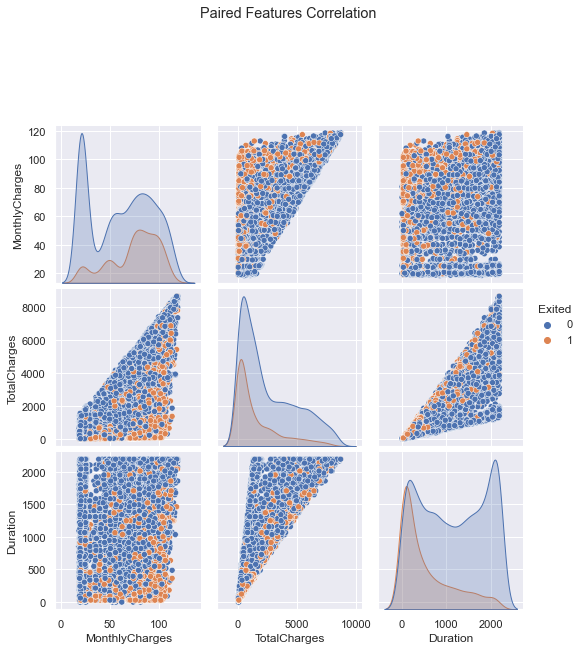

In [27]:
sns.set(rc = {'figure.figsize':(12,8)}) # setting the size
ax = sns.pairplot(df_clean, vars=df_clean[['MonthlyCharges', 'TotalCharges', 'Duration']], hue='Exited')  # plotting a  pairplot 
ax.fig.suptitle('Paired Features Correlation', y=1.2); # setting the title

So, at first glance, some features are quite strongly correlated. For example, total charges and monthly charges for services: with the growth of the former, the latter also grow. Another positive and expected correlation is observed between total charges and duration of the contract.

At the same time, there is no significant correlation between the target feature and any of the quantitative variables.

Let's try to build a correlation matrix for the same features to see if our visual observations are confirmed. Since the plots show that the dependence is not linear in most cases, we use the Spearman correlation as a method:

In [28]:
df_clean[['MonthlyCharges', 'TotalCharges', 'Duration']].corr(method='spearman') # printing correlation matrix

,MonthlyCharges,TotalCharges,Duration
MonthlyCharges,1.000000,0.638211,0.273912
TotalCharges,0.638211,1.000000,0.888709
Duration,0.273912,0.888709,1.000000


The correlation matrix confirmed our observations. Next, let's check our quantitative variables for outliers:

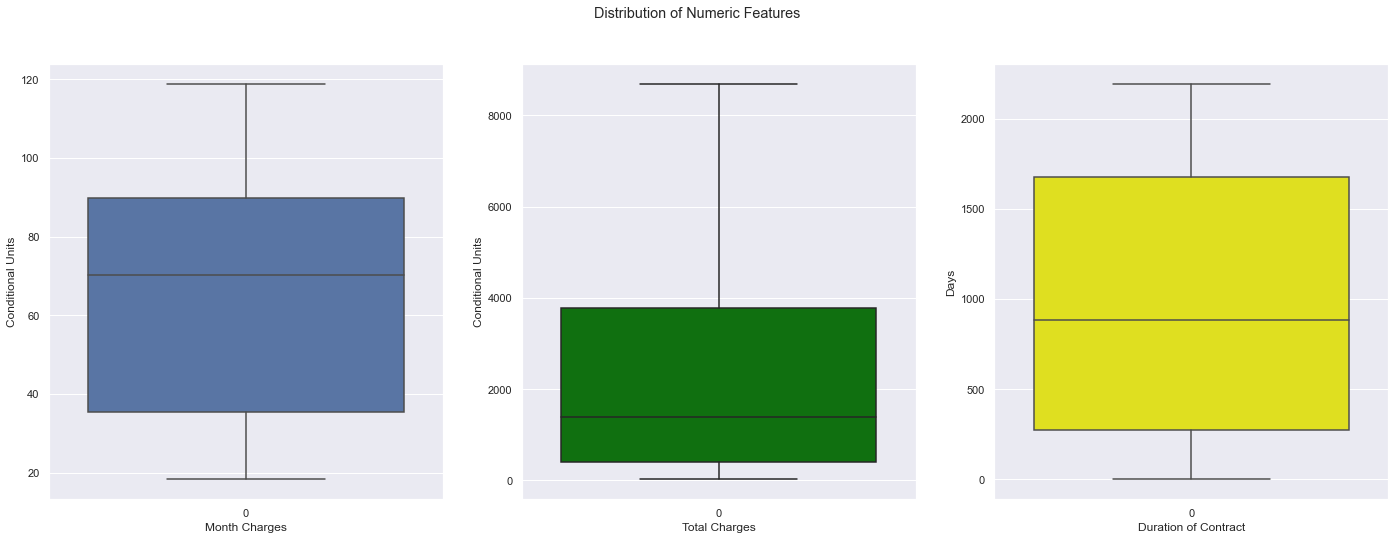

In [29]:
# plotting boxplots for quantitative features
fig, axes = plt.subplots(1, 3, figsize=(24, 8))
sns.boxplot(data=df_clean['MonthlyCharges'], ax=axes[0])
sns.boxplot(data=df_clean['TotalCharges'], ax=axes[1], color='green')
sns.boxplot(data=df_clean['Duration'], ax=axes[2], color='yellow')
axes[0].set_xlabel('Month Charges')
axes[0].set_ylabel('Conditional Units')
axes[1].set_xlabel('Total Charges')
axes[1].set_ylabel('Conditional Units')
axes[2].set_xlabel('Duration of Contract')
axes[2].set_ylabel('Days')
fig.suptitle('Distribution of Numeric Features');

None of the boxplots show values outside the 1.5 interquartile range on either side. Let's check the correctness of the plots by visualizing the statistics for each column:

In [30]:
# checking the statistics on the quantitative features
for feature in ['MonthlyCharges', 'TotalCharges', 'Duration']:
    print(df_clean[feature].describe())

count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: MonthlyCharges, dtype: float64
count    7043.000000
mean     2279.798992
std      2266.730170
min        18.800000
25%       398.550000
50%      1394.550000
75%      3786.600000
max      8684.800000
Name: TotalCharges, dtype: float64
count    7043.000000
mean      985.996166
std       747.587844
min         0.000000
25%       273.000000
50%       883.000000
75%      1676.000000
max      2191.000000
Name: Duration, dtype: float64


So, we can see that in the case of monthly charges, the median and the mean are quite close, in the other two cases they diverge more. We cannot say that there are outliers or erroneous values are in the dataframe.

Next, check if these features are normally distributed:

In [31]:
# checking if features are normally distributed:
for dist in ['MonthlyCharges', 'TotalCharges', 'Duration']:
    print(dist, st.jarque_bera(df_clean[dist]))

MonthlyCharges Jarque_beraResult(statistic=520.9006078123073, pvalue=0.0)
TotalCharges Jarque_beraResult(statistic=1104.2393493571853, pvalue=0.0)
Duration Jarque_beraResult(statistic=632.1698376799734, pvalue=0.0)


The resulting statistics are very different from zero: the distributions are clearly not normal.

Let's move on to categorical variables. Since the number of values in each of them is small, we will visualize categorical features through pie charts:

In [32]:
# creating a list of categorical features
cat_cols = list(df_clean.drop(columns=['MonthlyCharges', 'TotalCharges', 'Duration']).columns)
cat_cols

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'Type',
 'PaperlessBilling',
 'PaymentMethod',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'MultipleLines',
 'Exited']

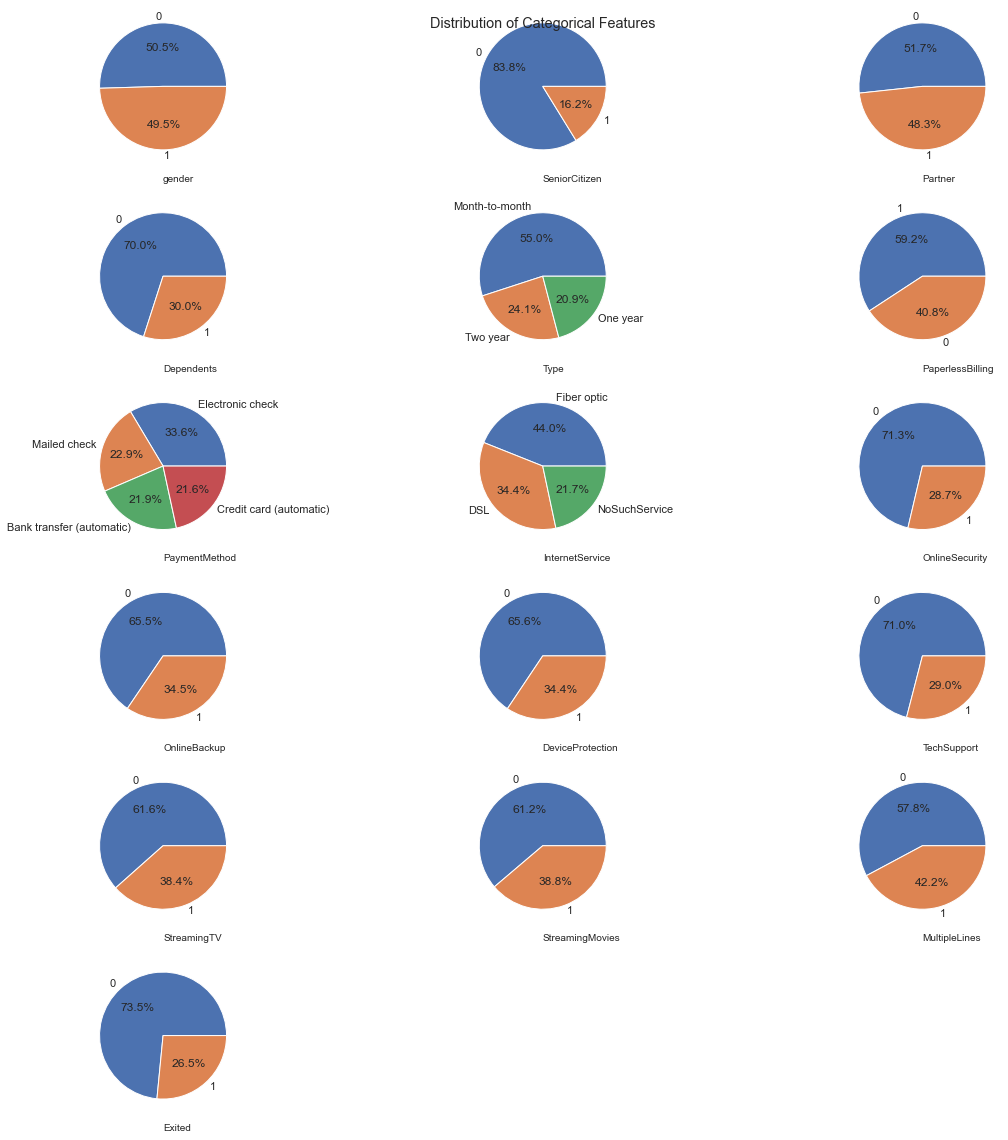

In [33]:
# plotting a pie diagram for each selected  feature
fig = plt.figure(figsize=(16, 16))
for i in range(len(cat_cols)):
    plt.subplot(6,3,i+1)
    plt.pie(df_clean[cat_cols[i]].value_counts(), labels=df_clean[cat_cols[i]].value_counts().index,
            autopct='%1.1f%%')
    plt.text(0, -1.5, cat_cols[i], fontsize=10)
    plt.tight_layout()
    plt.axis('off')
fig.suptitle('Distribution of Categorical Features')
plt.show();

The resulting pie charts show that men and women among the operator's customers are approximately equal, half of them have a spouse, while 30% have children. More than half of customers enter into monthly contracts (perhaps in order to avoid possible penalties due to premature termination), but among the 4 payment methods, preferences are divided almost equally. 22% of customers have only a telephone connection, while there are users who use only the Internet. On average, only a third of subscribers use various Internet-related services.
From the available datasets, as well as from the summary one, it is impossible to understand which subscribers use which services, let's try to figure it out:

In [34]:
# calculating the share of customers in terms of servives
both = internet.merge(phone, on='customerID', how='inner') 
print(len(both)/len(df))
only_internet = internet[~internet['customerID'].isin(both['customerID'])]
print(len(only_internet)/len(df))
only_phone = phone[~phone['customerID'].isin(both['customerID'])]
len(only_phone)/len(df)

0.686497231293483
0.09683373562402385


0.21666903308249325

So, almost 69% of customers have both services connected, approx. 22% only phone, but only 10% of users use only the Internet.

If we pay attention to the size of the last two datasets, their number is equal to the number of NaNs in the combined dataframe, respectively: 682 and 1526. After combining the tables, it was not obvious that these are exactly the clients with only a phone or only with the Internet, since the lack of a multiline, which in the task is interpreted as "connecting a telephone to several lines at the same time" does not exclude the presence of a telephone, the telephone line can be one, and the Internet - optical fiber. 

In the last pie chart, we can clearly see the class imbalance between current and left customers: about 3 to 1, fortunately for the Company.

Next, let's analyze some of the most obvious features that could affect customer churn. in particular, let's compare the average monthly costs of active and left customers:

In [35]:
avg_charges = df_clean.pivot_table(index='Exited', values='MonthlyCharges',  aggfunc=['mean']) # creating a pivot with statistics
avg_charges

,mean
,MonthlyCharges
Exited,
0,61.265124
1,74.441332


So, the difference is quite noticeable, on average, left users paid more per month. However, we cannot say with certainty that they had less favorable tariffs, perhaps they had more services on average.

Next, check the ratio of subscribers by type of contract:

In [36]:
contact_type = df_clean.pivot_table(index=['Exited', 'Type'], values='Dependents',   aggfunc=['count']) # creating a pivot with statistics
contact_type


count
                      Dependents
Exited Type                     
0      Month-to-month       2220
       One year             1307
       Two year             1647
1      Month-to-month       1655
       One year              166
       Two year               48

It is obvious that among the left customers, the absolute majority are those who had a monthly contract. That is, this featureis important.
Next, we will find out how much the minimum, maximum and average contract is valid in both groups:

In [37]:
avg_duration = df_clean.pivot_table(index='Exited', values='Duration',  aggfunc=['min', 'mean', 'max']) # creating a pivot with statistics
avg_duration

,min,mean,max
,Duration,Duration,Duration
Exited,,,
0,0,1144.447236,2191
1,30,547.352060,2191


Left users in the worst case make such a decision a month after the conclusion of the contract (perhaps in that particular month the quality of services was unsatisfactory), on average they make this decision after a year and a half - probably among them the majority of those who had long-term contracts.

Let's move on to checking the possible multicollinearity between features:

interval columns not set, guessing: ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PaperlessBilling', 'MonthlyCharges', 'TotalCharges', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines', 'Exited', 'Duration']


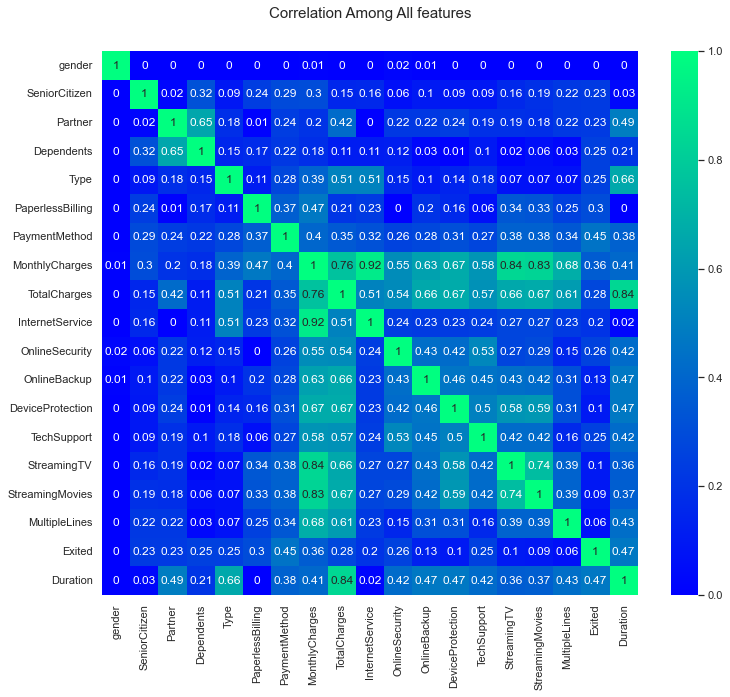

In [38]:
# creating a phik correlation matrix for all features
plt.figure(figsize=(12, 10))
sns.heatmap(round(df_clean.phik_matrix(),2),annot=True,cmap="winter")
plt.title('Correlation Among All features', y=1.05, size=15);


So, we will traditionally consider a correlation from 0.75 to be high. In our case, such a correlation exists between the total charges and monthly charges, which was obvious, and also between the total charges and the duration of the contract - equally obvious. In addition, we see a correlation between monthly charges and streaming TV and movie catalog, respectively. There is also a very high correlation between monthly charges and Internet service.

However, we know that not all correlation coefficients are statistically significant. So let's do another check:

interval columns not set, guessing: ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PaperlessBilling', 'MonthlyCharges', 'TotalCharges', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines', 'Exited', 'Duration']


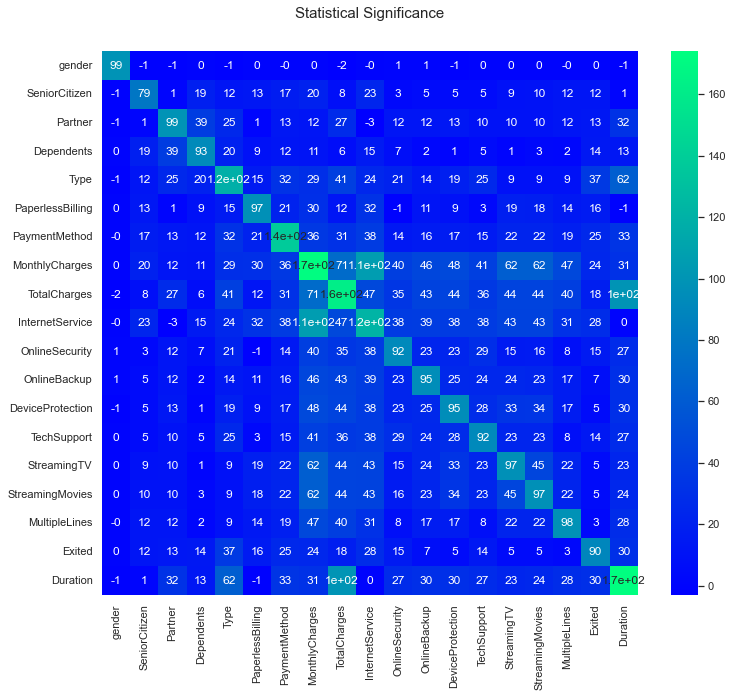

In [39]:
# creating a phik statistical significance matrix
plt.figure(figsize=(12, 10))
sns.heatmap(round(df_clean.significance_matrix()),annot=True,cmap="winter")
plt.title('Statistical Significance', y=1.05, size=15);


As far as we could understand from the information on the phik library, in order to determine multicollinearity, high correlation coefficients obtained on the previous matrix should have values greater than 5 on the matrix of statistical importance.
If our assumption is correct, then the pairwise correlation between the carges and contract duration is indeed important, and we should take this into account when processing data for machine learning. It is also significant for the monthly costs and services of the Internet, TV and movies, respectively.
Next, let's check which features are most important for predicting our target variable:

In [40]:
# checking the most important features for the target one
overview = df_clean.phik_matrix()
overview['Exited'].sort_values(ascending=False)

interval columns not set, guessing: ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PaperlessBilling', 'MonthlyCharges', 'TotalCharges', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines', 'Exited', 'Duration']


Exited              1.000000
Duration            0.474001
PaymentMethod       0.449125
MonthlyCharges      0.360050
PaperlessBilling    0.295754
TotalCharges        0.279152
OnlineSecurity      0.264580
TechSupport         0.254615
Dependents          0.253936
Type                0.251639
SeniorCitizen       0.233432
Partner             0.232930
InternetService     0.196202
OnlineBackup        0.126973
DeviceProtection    0.101516
StreamingTV         0.096865
StreamingMovies     0.093923
MultipleLines       0.059581
gender              0.000000
Name: Exited, dtype: float64

Among the features, arranged on a scale of importance, we see those that seemed completely non-obvious.
As far as correlated variables are concerned, total, monthly charges, and duration of the contract are among the most important features, therefore, in order to avoid multicollinearity, it is necessary to get rid of one of them. Total costs correlate with both validity and monthly charges, while monthly charges correlate weakly with duration. Of the three variables, total chargesis the least important. All this allows us to remove the last feature.

As for the other features for which we found a high correlation, their importance for the target feature is much lower. However, let's try to exclude streaming services and gender from the final dataframe as well.

In [41]:
df_ml = df_clean.drop(columns=['TotalCharges', 'gender', 'StreamingTV', 'StreamingMovies']) # deleting irrelevant features

**Conclusions**
So, in the course of this phase, we conducted an EDA, examined in detail each feature and the corresponding dependencies and patterns, and did further dataframe processing.

It's time to prepare the samples for machine learning.

### Samples Preparation for ML

In [42]:
features = df_ml.drop(columns=['Exited']) # separating features for target prediction
target = df['Exited']  # separating the target
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25,stratify=df_ml['Exited'],  random_state=41022) # splitting df in 2 samples

C:\Users\Tatiana\anaconda3\envs\praktikum_new\lib\site-packages\sklearn\utils\__init__.py:806: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return floored.astype(np.int)
C:\Users\Tatiana\anaconda3\envs\praktikum_new\lib\site-packages\sklearn\utils\__init__.py:806: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish 

In [43]:
# checking if split worked properly
print(len(df_ml), len(features_train),  len(features_test), sep='\n') # checking the result
print(len(df_ml) == (len(features_train) + len(features_test)))  #  checking the result

7043
5282
1761
True


In [44]:
# checking if split worked properly
for target in [target_train, target_test]: # interating over the target in samples
    print(target.mean()) # printing the ratio of toxic comments

0.2654297614539947
0.26519023282226006


**Conclusions**
So, the samples are ready. It's time to start machine learning by testing different models.

## Machine learning

Let's get straight to machine learning. We will train and test 2 traditional classification models: logistic regression and random forest, as well as two gradient boosting models. After that, we will  analyze that model in detail, which will show the highest value of the area under the ROC curve.
First, for traditional models, we will carry out specific data preprocessing:
### Logistic Regression

So, we know that logistic regression is not able to work with uncoded categorical features. In addition, we know that models based on "distance between features" (Euclidean distance), including regression, perform better if the features used in training are standardized. Let's perform the appropriate transformations using the pipeline:

In [45]:
# creating lists of features
num_cols = features_train.select_dtypes(exclude=['object']).columns.tolist()
cat_cols = features_train.select_dtypes(include=['object']).columns.tolist()

# creating a pipeline for quantitative features
num_pipe = make_pipeline(StandardScaler())
# creating a pipeline for categorical features
cat_pipe = make_pipeline(OneHotEncoder(handle_unknown='ignore', sparse=False))

# transforming
full_pipe = ColumnTransformer([('num', num_pipe, num_cols),('cat', cat_pipe, cat_cols)])

# creating a model
logreg = make_pipeline(
    full_pipe, LogisticRegression(class_weight='balanced', random_state=41022))


In [46]:
logreg_params = {'logisticregression__max_iter': range (100,1000, 20), 'logisticregression__penalty':
                  ['l1', 'l2'], 'logisticregression__solver': ['liblinear'], 'logisticregression__C': [0.5, 1.0, 1.5]} # defining parameters for cross-validation

logreg_grid = RandomizedSearchCV(estimator=logreg, param_distributions=logreg_params, scoring='roc_auc', n_jobs=-1, random_state=41022) # creating a Randomizedsearch 
logreg_grid.fit(features_train, target_train) # fitting the model
print('AUC-ROC of the best logistic regression is', logreg_grid.best_score_, 'with the hyperparameters', logreg_grid.best_params_) # printing the best result

C:\Users\Tatiana\anaconda3\envs\praktikum_new\lib\site-packages\sklearn\model_selection\_split.py:670: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_folds = np.zeros(n_samples, dtype=np.int)
C:\Users\Tatiana\anaconda3\envs\praktikum_new\lib\site-packages\sklearn\model_selection\_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to sp

AUC-ROC of the best logistic regression is 0.8385468442167372 with the hyperparameters {'logisticregression__solver': 'liblinear', 'logisticregression__penalty': 'l1', 'logisticregression__max_iter': 540, 'logisticregression__C': 0.5}


C:\Users\Tatiana\anaconda3\envs\praktikum_new\lib\site-packages\sklearn\model_selection\_search.py:793: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)
C:\Users\Tatiana\anaconda3\envs\praktikum_new\lib\site-packages\sklearn\utils\validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
C:\Users\Tatiana\anaconda3\envs\praktikum_new\lib\site-packages\sklearn\utils\validation.py:179: DeprecationWarning: distutils Version classes are depreca

Unfortunately, the logistic regression quality metric did not reach the set threshold.
Let's move on to the next model, which is random forest.

### Random Forest

In this case, we also have to perform some transformations before training the model:

In [47]:
# creating lists of features
cat_cols = features_train.select_dtypes(include=['object']).columns.tolist()

# creating a pipeline for categorical features
cat_pipe = make_pipeline(OrdinalEncoder())

# transforming
full_pipe = ColumnTransformer([('cat', cat_pipe, cat_cols)])

# creating a model
rf = make_pipeline(full_pipe, RandomForestClassifier(class_weight='balanced', random_state=41022))


In [48]:
rf_params = {'randomforestclassifier__criterion': ['gini', 'entropy'], 'randomforestclassifier__n_estimators': range (10, 201, 10), 
                  'randomforestclassifier__max_depth': range (1,11)} # defining parameters for cross-validation
rf_grid = RandomizedSearchCV(estimator=rf, param_distributions=rf_params, scoring='roc_auc', n_jobs=-1, random_state=41022) # creating a Randomizedsearch 
rf_grid.fit(features_train, target_train) # fitting the model
print('AUC-ROC  of the best random forest is', rf_grid.best_score_, 'with the hyperparameters', rf_grid.best_params_) # printing the best result

C:\Users\Tatiana\anaconda3\envs\praktikum_new\lib\site-packages\sklearn\model_selection\_split.py:670: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_folds = np.zeros(n_samples, dtype=np.int)
C:\Users\Tatiana\anaconda3\envs\praktikum_new\lib\site-packages\sklearn\model_selection\_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to sp

AUC-ROC  of the best random forest is 0.8118497781651446 with the hyperparameters {'randomforestclassifier__n_estimators': 90, 'randomforestclassifier__max_depth': 6, 'randomforestclassifier__criterion': 'entropy'}


C:\Users\Tatiana\anaconda3\envs\praktikum_new\lib\site-packages\sklearn\tree\tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
C:\Users\Tatiana\anaconda3\envs\praktikum_new\lib\site-packages\sklearn\tree\tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you w

So, the random forest did not reach either the specified threshold, moreover, it showed the worst results in comparison with logistic regression. Let's move on to gradient boosting models.

### Gradient Boosting

So, we will try out two models of gradient boosting: CatBoost and LGBM. Since both models do not require preliminary scaling and coding of categorical features, let's start training right away:

In [49]:
categoric = ['Type', 'PaymentMethod', 'InternetService'] # создаём список кат. признаков для передачи в параметр
model = CatBoostClassifier(random_seed=41022, class_weights=[1, 3]) # creating a model
param_distributions = {'iterations': range (10, 110, 20), 'max_depth': range (1,6), 'learning_rate': [0.1, 0.2, 0.3]}   #  defining parameters for cross-validation
grid = RandomizedSearchCV(model, param_distributions, scoring='roc_auc', n_jobs=-1, random_state=41022) # creating a Randomizedsearch
grid.fit(features_train, target_train, cat_features=categoric, verbose=10) # fitting the model
print('AUC-ROC  of the best Catboost is', grid.best_score_, 'with the hyperparameters', grid.best_params_ ) # printing the best result

C:\Users\Tatiana\anaconda3\envs\praktikum_new\lib\site-packages\sklearn\model_selection\_split.py:670: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_folds = np.zeros(n_samples, dtype=np.int)
C:\Users\Tatiana\anaconda3\envs\praktikum_new\lib\site-packages\sklearn\model_selection\_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to sp

0:	learn: 0.6368867	total: 176ms	remaining: 15.7s
10:	learn: 0.4735040	total: 492ms	remaining: 3.54s
20:	learn: 0.4564398	total: 743ms	remaining: 2.44s
30:	learn: 0.4457003	total: 1.02s	remaining: 1.95s
40:	learn: 0.4320463	total: 1.41s	remaining: 1.69s
50:	learn: 0.4238182	total: 1.83s	remaining: 1.4s
60:	learn: 0.4141895	total: 2.24s	remaining: 1.06s
70:	learn: 0.4064280	total: 2.54s	remaining: 681ms
80:	learn: 0.4015417	total: 2.73s	remaining: 303ms
89:	learn: 0.3976293	total: 2.89s	remaining: 0us
AUC-ROC  of the best Catboost is 0.8726496081597637 with the hyperparameters {'max_depth': 4, 'learning_rate': 0.3, 'iterations': 90}


So, CatBoost showed the best result of the three models, and most importantly, we finally reached the set threshold. Let's move on to the latest model:

In [50]:
# chaning type of categorical features
for col in categoric:
    features_train[col] = features_train[col].astype('category')
    features_test[col] = features_test[col].astype('category')
features_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5282 entries, 5705 to 487
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   SeniorCitizen     5282 non-null   int64   
 1   Partner           5282 non-null   int64   
 2   Dependents        5282 non-null   int64   
 3   Type              5282 non-null   category
 4   PaperlessBilling  5282 non-null   int64   
 5   PaymentMethod     5282 non-null   category
 6   MonthlyCharges    5282 non-null   float64 
 7   InternetService   5282 non-null   category
 8   OnlineSecurity    5282 non-null   int64   
 9   OnlineBackup      5282 non-null   int64   
 10  DeviceProtection  5282 non-null   int64   
 11  TechSupport       5282 non-null   int64   
 12  MultipleLines     5282 non-null   int64   
 13  Duration          5282 non-null   int32   
dtypes: category(3), float64(1), int32(1), int64(9)
memory usage: 490.5 KB


In [51]:
model =  LGBMClassifier(objective='binary', class_weight='balanced', random_seed=41022) # creating a model
param_distributions = {'n_estimators': range (5, 110, 5), 'num_leaves': [5,10], 'max_depth': range (1,11), 'learning_rate': [0.3, 0.4, 0.5, 0.6, 0.7]}   #  defining parameters for cross-validation
clf_l = RandomizedSearchCV(model, param_distributions, scoring='roc_auc', n_jobs=-1, random_state=41022) # creating a Randomizedsearch
clf_l.fit(features_train, target_train) #  fitting the model
print('AUC-ROC  of the best LGBM is', clf_l.best_score_, 'with the hyperparameters', clf_l.best_params_ ) # printing the best result


C:\Users\Tatiana\anaconda3\envs\praktikum_new\lib\site-packages\sklearn\model_selection\_search.py:269: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  random_state=rnd):
C:\Users\Tatiana\anaconda3\envs\praktikum_new\lib\site-packages\sklearn\model_selection\_split.py:670: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you

AUC-ROC  of the best LGBM is 0.8954932669777562 with the hyperparameters {'num_leaves': 5, 'n_estimators': 105, 'max_depth': 5, 'learning_rate': 0.6}


C:\Users\Tatiana\anaconda3\envs\praktikum_new\lib\site-packages\sklearn\model_selection\_search.py:793: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)


In [52]:
predict_proba_lgbm = clf_l.predict_proba(features_test)[:, 1] # calculating probability of the class 1
roc_auc_test_lgbm = roc_auc_score(target_test, predict_proba_lgbm)  # calculating AUC-ROC
roc_auc_test_lgbm

0.9150981800370015

LGBM showed an even better result: we used it on the test sample and exceeded the established threshold by almost four percent. We choose this model for classifying customers by outflow, then we will analyze it and check for sanity.

### LGBM Model Analysis and Sanity Check

So, first of all, we have to build a plot on the importance of the features for the model. Since it is impossible to use the RandomizedSearch object to call the corresponding parameter, we will rebuild the model with optimal hyperparameters and train it.

In [53]:
# fitting the model with the best hyperparameters once again and calculating the metrics
final_model = LGBMClassifier(objective='binary', class_weight='balanced', random_seed=41022, 
                             num_leaves = 5, n_estimators = 85, max_depth = 5, learning_rate = 0.6)
final_model.fit(features_train, target_train)
final_predictions = final_model.predict(features_test)
final_probabilities = final_model.predict_proba(features_test)[:, 1]
final_auc_roc = roc_auc_score(target_test, final_probabilities)
final_accuracy = accuracy_score(target_test, final_predictions)
final_f1 = f1_score(target_test, final_predictions)

In [54]:
# creating a summary df:
lst = [final_auc_roc, final_accuracy, final_f1]
metrics = pd.DataFrame(lst, index =['AUC-ROC', 'accuracy', 'f1'], columns=['values'])
metrics.head()

,values
AUC-ROC,0.916468
accuracy,0.842703
f1,0.732883


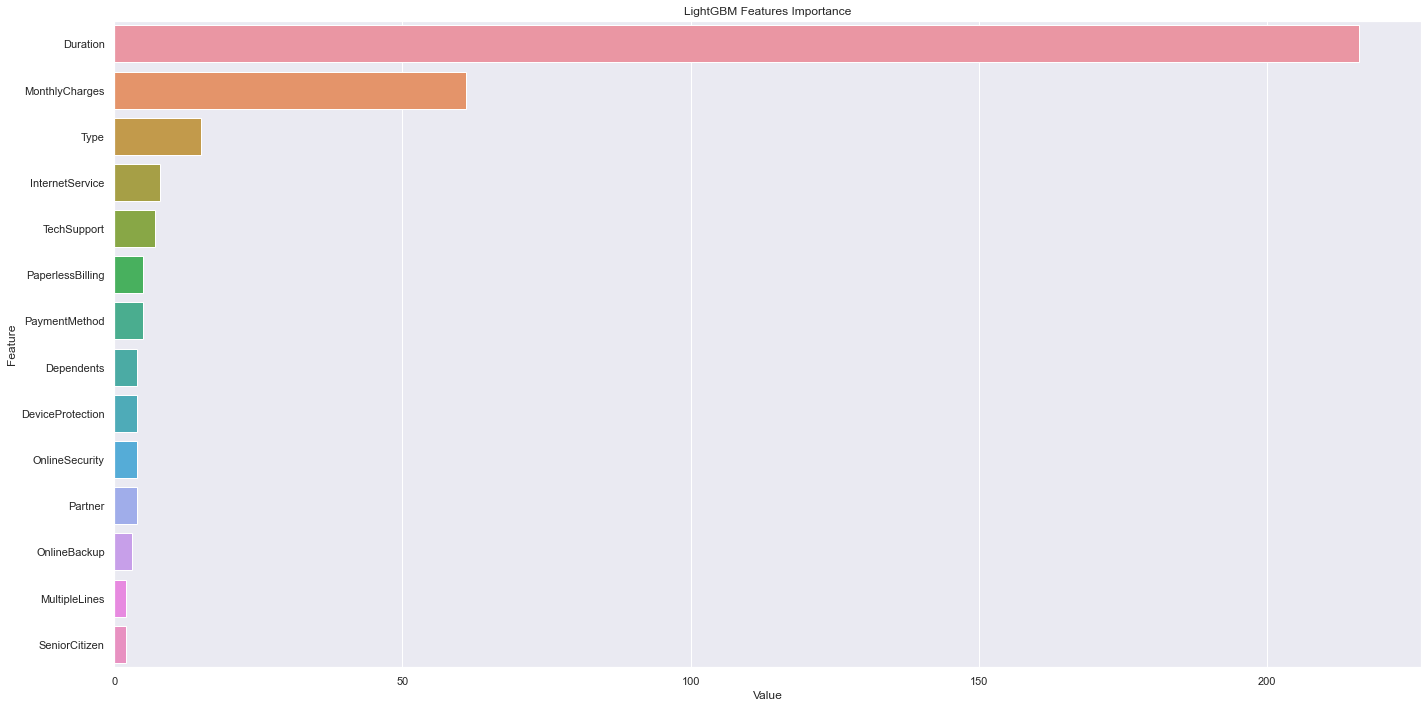

In [55]:
# plotting the features importance
feature_imp = pd.DataFrame(sorted(zip(final_model.feature_importances_,features_train.columns)), columns=['Value','Feature'])
plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features Importance')
plt.tight_layout()
plt.show()


So, for this model, the feature importance is slightly different from the one that phik determined, while the monthly costs and the duration of the contract are still in the top 3.

Next, we will check in which cases our model worked better, and in which it was most wrong:

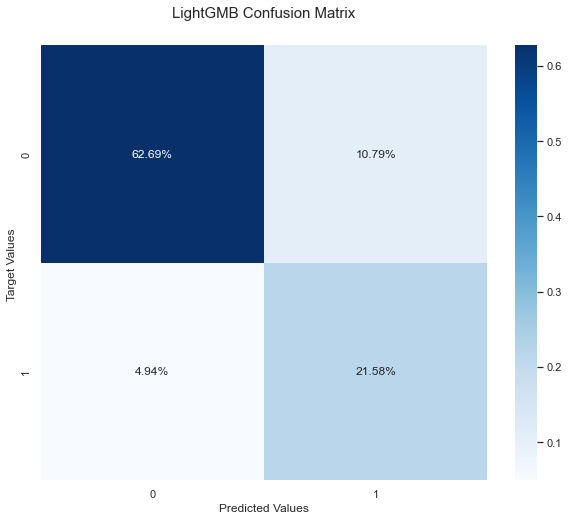

In [56]:
# plotting the confusion matrix
plt.figure(figsize=(10,8)) 
cf_matrix = confusion_matrix(target_test, final_predictions) 
ax =  sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')
ax.set_title('LightGMB Confusion Matrix', y=1.05, size=15) 
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Target Values '); 

In general, the model coped well with the task: in 85% of cases, it correctly identified the left and active customers. As for errors, she more often made a type 1 error, predicted the first class to zero.
Next, let's see what our ROC curve looks like and the area under it.

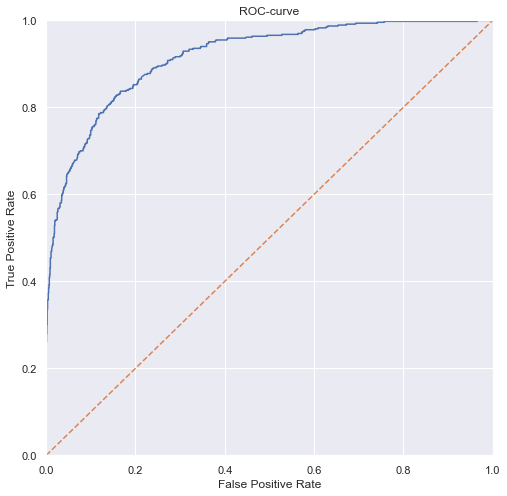

In [57]:
# plotting the roc-curve, as well as the curve of constant model
fpr, tpr, thresholds = roc_curve(target_test, final_probabilities)
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.show();

The area under our roc-curve looks quite impressive. Despite the fact that there is also a straight line of a random model on the chart, and the two lines clearly do not coincide, we will nevertheless make a separate check of our model for sanity.

In [58]:
# creating a baseline model and calculating the relevant metrics
baseline = DummyClassifier(strategy='stratified')
baseline.fit(features_train, target_train)
baseline_predictions = baseline.predict(features_test)
baseline_probabilities = baseline.predict_proba(features_test)[:, 1]
baseline_auc_roc = roc_auc_score(target_test, baseline_probabilities)
baseline_accuracy = accuracy_score(target_test, baseline_predictions)
baseline_f1 = f1_score(target_test, baseline_predictions)
print(f'Baseline model achieved the following metric scores: AUC-ROC {baseline_auc_roc}, accuracy {baseline_accuracy},F1 {baseline_f1}.')

Baseline model achieved the following metric scores: AUC-ROC 0.5073275105990753, accuracy 0.599091425326519,F1 0.23593073593073594.


So, the baseline metrics are clearly different from the metrics of our model - they are much lower. The task has been solved.

## Study Results 

In the course of this study, we carried out extensive work on the analysis of available data: after appropriate preparation, an data discovery was carried out, we studied the data for multicollinearity, removed some and created new features.
The final dataset was divided into samples and prepared for machine learning depending on the model. As a result, we tested 4 of them:
1. linear regression;
2. random forest;
3. Catboost;
4. LightGBM.

**LightGBM performed best on the test set with an AUC-ROC target metric of 0.92, 4 percent higher than the threshold.**

This model was examined in terms of the importance of features for prediction, and also tested for sanity.

In general, given the specifics of our task, we can consider the work done successful. Probably, more detailed hyperparameter tuning or more "scientific" feature engineering would have made it possible to achieve even better results.

## Additional Task Telecom

1. First of all, according to the task, we will check out  the statistics for each group:

In [59]:
active = df[df['Exited']==0]['MonthlyCharges']
active.describe() # stats on active clients

count    5174.000000
mean       61.265124
std        31.092648
min        18.250000
25%        25.100000
50%        64.425000
75%        88.400000
max       118.750000
Name: MonthlyCharges, dtype: float64

In [60]:
left = df[df['Exited']==1]['MonthlyCharges']
left.describe() # stats on left clients

count    1869.000000
mean       74.441332
std        24.666053
min        18.850000
25%        56.150000
50%        79.650000
75%        94.200000
max       118.350000
Name: MonthlyCharges, dtype: float64

So, the minimum and maximum values in both groups are almost identical. The standard deviation is much higher in the group of active clients - there is a greater spread in it. On the other hand, in both groups, the mean and median are quite close to each other - perhaps the distributions are not so far from normal. In general, looking at the obtained values, one can also assume that there are no outliers in the samples. Let's test our assumptions with plots:

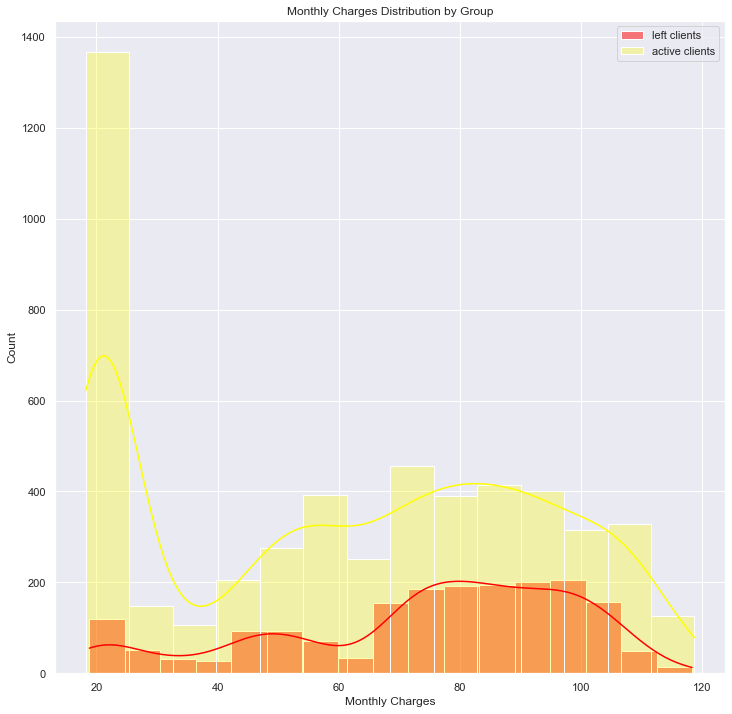

In [61]:
# plotting histograms on both groups
sns.set(rc = {'figure.figsize':(12, 12)})
sns.histplot(data=df[df['Exited']==1], x='MonthlyCharges', color="red", label="left clients", kde=True) 
sns.histplot(data=df[df['Exited']==0], x='MonthlyCharges', color="yellow", label="active clients", kde=True, alpha=0.3) 
plt.xlabel('Monthly Charges') 
plt.title('Monthly Charges Distribution by Group') 
plt.legend(); 

Analyzing the histograms, we can conclude that the distributions are still far from normal. Especially in the group of active clients, many of them pay at least a month. Such clients were also among those who left, their share was also relatively high. That is, from this point of view, we cannot say that active clients have remained active, since their monthly costs are lower. Perhaps, after the massive outflow, the company somehow reacted to it by lowering tariffs. Nevertheless, it is more logical to assume that those subscribers who paid and pay little are those who have 1 service connected (either Internet or telephone).

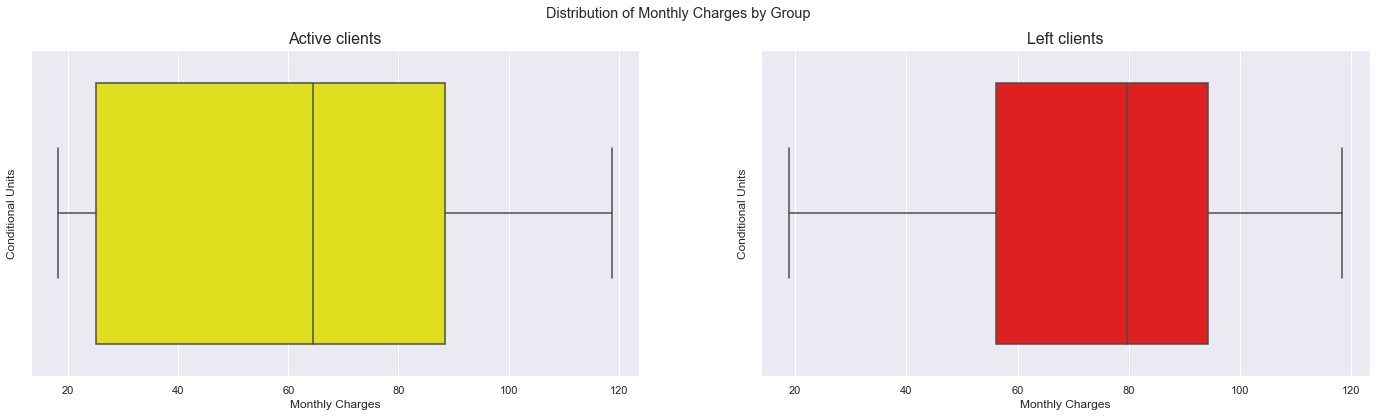

In [62]:
# plotting boxplots on both groups
fig, axes = plt.subplots(1, 2, figsize=(24, 6))
sns.boxplot(data=df[df['Exited']==0], x='MonthlyCharges', ax=axes[0],  color='yellow')
sns.boxplot(data=df[df['Exited']==1], x='MonthlyCharges', ax=axes[1], color='red')
axes[0].set_xlabel('Monthly Charges')
axes[1].set_xlabel('Monthly Charges')
axes[0].set_ylabel('Conditional Units')
axes[1].set_ylabel('Conditional Units')
axes[0].set_title('Active clients', fontsize = 16)
axes[1].set_title('Left clients', fontsize = 16)
fig.suptitle('Distribution of Monthly Charges by Group');

2. Indeed, in none of the samples there are values that lie outside the 1.5 interquartile range on the right and left. The absence of outliers allows us to compare the monthly payment distributions in the two groups of subscribers using a standard Student's t-test. Our task is to compare the sample means of two independent populations, so we will use the scipy.stats.ttest_ind() method, where the equal_var = False parameter, since the samples are of different sizes and there is no certainty that their variances are clearly different.

Let's form the null and alternative hypotheses:
  - H0: the average monthly costs of active and departed customers are the same;
  - H1: The average monthly costs of active and departed customers differ.

In [63]:
alpha = 0.01 # setting the level of stats significance
results = st.ttest_ind(active, left, equal_var = False) #  testing the hypotheses
print('P-value:', results.pvalue)
if results.pvalue < alpha:
    print("Rejecting the null hypothesis")
else:
    print("Failed to reject the null hypothesis")

P-value: 8.592449331547538e-73
Rejecting the null hypothesis


So, according to the result of the t-test, we reject the null hypothesis, that is, the average monthly costs in the two groups are different. We can assume that this is why monthly costs are one of the most important features for classifying subscribers.

3. Next, according to the task, let's move on to plots depending on the range of connected services.
From previous exploratory data analysis, we know that those users for whom the values in the 'MultipleLines' attribute are missing use only the Internet, those for which the values in the 'InternetService' attribute are missing use only the telephone. All others have both services connected. Let's depict users by groups using a pie chart, for this we first add an additional feature to our dataframe:

In [64]:
# adding an additional feature to the dataframe
df['WhichService'] = 'Both'
df['WhichService'][df['InternetService']=='NoSuchService']='Only Phone'
df['WhichService'][df['customerID'].isin(only_internet['customerID'])] = 'Only Internet'
df['WhichService'].value_counts()

Both             4835
Only Phone       1526
Only Internet     682
Name: WhichService, dtype: int64

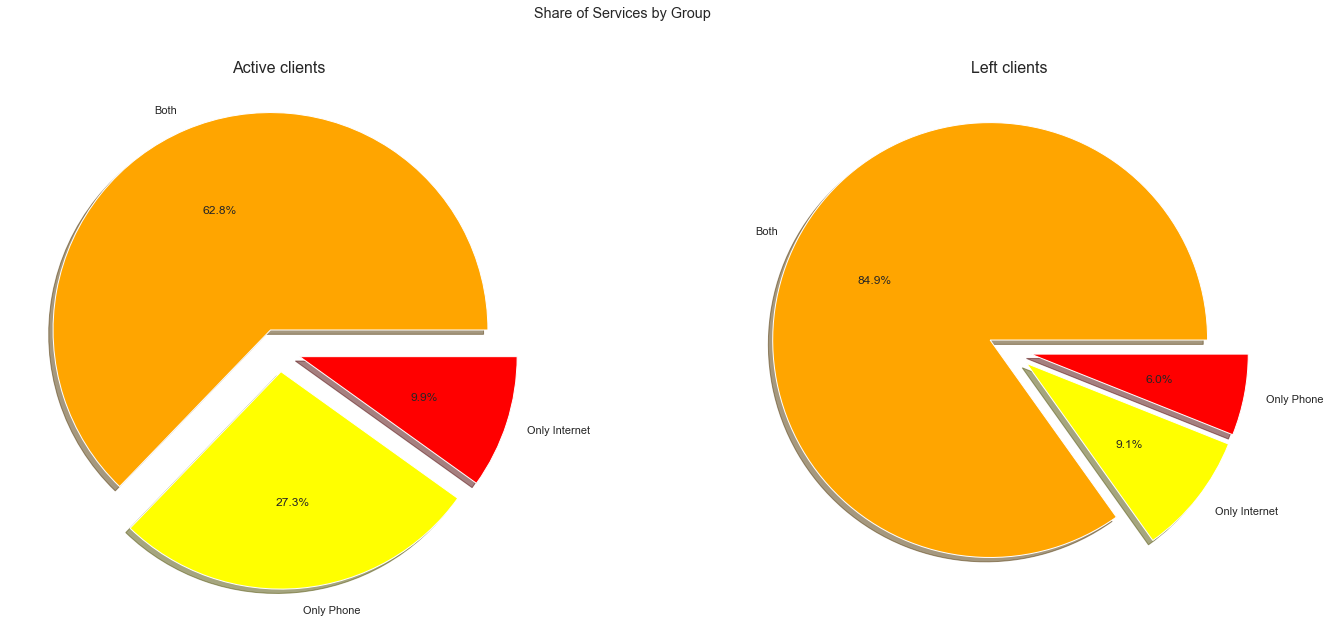

In [65]:
# plotting piechars for each group
mycolors = ["orange", "yellow", "red"]
fig, axes = plt.subplots(1, 2, figsize=(24, 10))
axes[0].pie(df[df['Exited']==0]['WhichService'].value_counts(), shadow=True, explode=(0.1, 0.1, 0.1), 
            colors = mycolors, labels=df[df['Exited']==0]['WhichService'].value_counts().index, autopct='%1.1f%%')
axes[1].pie(df[df['Exited']==1]['WhichService'].value_counts(), shadow=True, explode=(0.1, 0.1, 0.1),
            colors = mycolors, labels=df[df['Exited']==1]['WhichService'].value_counts().index,  autopct='%1.1f%%')
axes[0].set_title('Active clients', fontsize = 16)
axes[1].set_title('Left clients', fontsize = 16)
fig.suptitle('Share of Services by Group');

Based on the obtained pie charts, in both groups, the vast majority are subscribers connected to both services. In the second group (departed clients), this one is even higher for them. Perhaps our additional feature can be used as an additional one for machine learning.

Further, if we correctly interpreted the task "For each, build any two graphs depicting:
* share of telephony users;
* share of Internet users._",

Let's build another graph on the same basis for both groups, this time we will choose a bar chart.

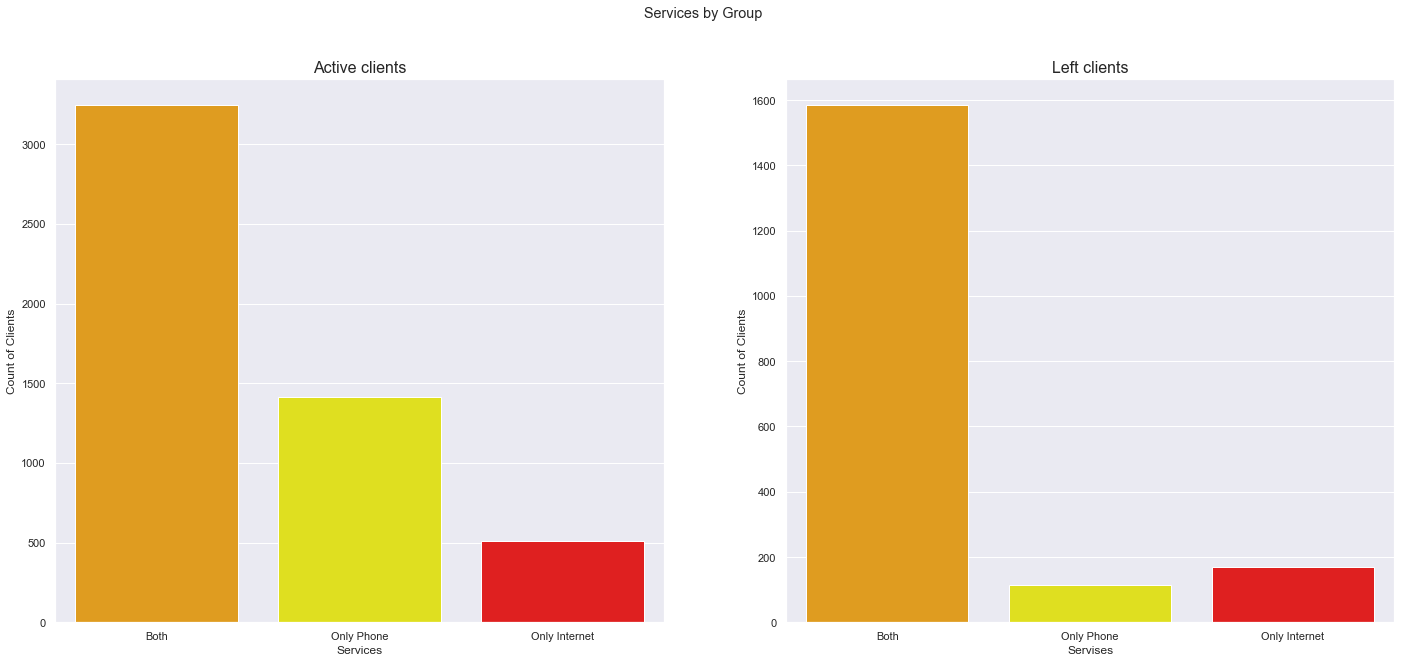

In [66]:
# Plotting barplots for each group
mycolors = ["orange", "yellow", "red"]
order = ['Both', 'Only Phone', 'Only Internet']
fig, axes = plt.subplots(1, 2, figsize=(24, 10))
sns.barplot(data=df[df['Exited']==0], x=df[df['Exited']==0]['WhichService'], order=order,
            y=df[df['Exited']==0]['MonthlyCharges'], palette=mycolors, estimator=len, ax=axes[0])
sns.barplot(data=df[df['Exited']==1], x=df[df['Exited']==1]['WhichService'], order=order,
            estimator=len, y=df[df['Exited']==1]['MonthlyCharges'], palette=mycolors,
            ax=axes[1])
axes[0].set_xlabel('Services')
axes[1].set_xlabel('Servises')
axes[0].set_ylabel('Сount of Clients')
axes[1].set_ylabel('Сount of Clients')
axes[0].set_title('Active clients', fontsize = 16)
axes[1].set_title('Left clients', fontsize = 16)
fig.suptitle('Services by Group');

**Conclusions**

So, in the course of this small study, two groups of the company's clients were analyzed: active and departed, in terms of:
- monthly expenses;
- connected services.
As a result of the work done, it was possible to establish that the average costs differ in different groups, for this reason, this feature is an important pattern for classifying users.

In terms of connected services, the shares of the 3 categories in the two groups differ. The absolute majority of subscribers used/are using both services. At the same time, there were 22% more of those among the departed clients. Further, we noticed that among the active clients there are more of those who have only a phone connected, but only used the Internet for approx. 10%. In the group of departed clients, on the contrary, there are more of those who used only the Internet, while the share of only telephone subscribers is very small - 6%.

Given the fairly clear differences in the type of connected services between active and affected clients, we can assume that this additional feature can be useful for the classification problem.